# CCS Concept Tree

This Notebook create a database of labeled concept pairs based on the Computing Classification System of ACM.<br>
You can find the xml [here](https://dl.acm.org/pb-assets/dl_ccs/acm_ccs2012-1626988337597.xml). 

In [2]:
import numpy as np
import pandas as pd
import networkx
import matplotlib.pyplot as plt


from Scripts.util import cartesianProductOfLists, stringPreprocessing

[nltk_data] Downloading package wordnet to /home/jcl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jcl/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
xml_path = 'Data/acm_ccs2012-1626988337597.xml'
# xml_df   = pd.read_xml(xml_path, xpath=".//skos:Concept", namespaces={'rdf':"http://www.w3.org/1999/02/22-rdf-syntax-ns#", "rdfs":"http://www.w3.org/2000/01/rdf-schema#", 'skos':"http://www.w3.org/2004/02/skos/core#", "xml": "http://www.w3.org/XML/1998/namespace", 'skosxl':"http://www.w3.org/2008/05/skos-xl#"})
xml_df   = pd.read_xml(xml_path)

# HasTopConcept and TopConceptOf are the same, only 13 values for the 13 top concepts
# narrower is for the concepts below and broader the concepts above

In [4]:
xml_df.tail()

,about,hasTopConcept,prefLabel,topConceptOf,narrower,broader
2109,10011007.10010940.10010941.10010949.10010957.1...,NaN,Power management,NaN,NaN,NaN
2110,10011007.10010940.10010941.10010949.10010957.1...,NaN,Process synchronization,NaN,NaN,NaN
2111,10011007.10010940.10010941.10010949.10010965.1...,NaN,Buffering,NaN,NaN,NaN
2112,10011007.10010940.10010941.10010949.10010965.1...,NaN,Input / output,NaN,NaN,NaN
2113,10011007.10010940.10010941.10010949.10010965.1...,NaN,Message passing,NaN,NaN,NaN


#### Processing and Modifying the data

In [5]:
## Adding Preferred label to ccs2012
xml_df.loc[xml_df['about'] == 'ccs2012', 'prefLabel'] = 'Computing Classification System 2012'

In [6]:
## Processing the preferred labels
xml_df['prefLabelProcessed'] = xml_df['prefLabel'].apply(stringPreprocessing)

In [7]:
## Remmoving useless columns
xml_df.drop(columns=['hasTopConcept'], inplace=True)

In [8]:
xml_df.head()

,about,prefLabel,topConceptOf,narrower,broader,prefLabelProcessed
0,ccs2012,Computing Classification System 2012,NaN,NaN,NaN,computing classification system 2012
1,10002944,General and reference,NaN,NaN,NaN,general reference
2,10002950,Mathematics of computing,NaN,NaN,NaN,mathematics computing
3,10002951,Information systems,NaN,NaN,NaN,information system
4,10002978,Security and privacy,NaN,NaN,NaN,security privacy


#### Building the xml from scrath...

In [9]:
def findPredecessorsAndSuccessorsFromDF(df, about, prefLabelProcessed):
    if(about in "ccs2012"):
        return 1
    
    if(not '.' in about):
        xml_df.loc[xml_df['about'] == about, 'topConceptOf'] = 'concept classification system 2012'
        xml_df.loc[xml_df['about'] == "ccs2012", 'narrower'].values[0].append(prefLabelProcessed)
        return 2
    else:
        all_concepts = about.split('.')
        predecessor = '.'.join(all_concepts[:-1])
        
        ## Adding the current node to the successors of `predecessor`
        xml_df.loc[xml_df['about'] == predecessor, 'narrower'].values[0].append(prefLabelProcessed)
            
        ## Adding the `predecessor` to the current node as broader
        xml_df.loc[xml_df['about'] == about, 'broader'] = xml_df.loc[xml_df['about'] == predecessor, 'prefLabelProcessed'].values[0]
                
        return 3
    

In [10]:
## Replaces the nans with lists to append successors
xml_df.narrower = xml_df.narrower.apply(lambda x: list())

In [11]:
## Computes successors and predecessors to each node
results = xml_df.apply(lambda x: findPredecessorsAndSuccessorsFromDF(xml_df, x.about, x.prefLabelProcessed), axis=1)
results.value_counts()#2100 leafs 13 roots

3    2100
2      13
1       1
dtype: int64

In [12]:
xml_df.head(15)

,about,prefLabel,topConceptOf,narrower,broader,prefLabelProcessed
0,ccs2012,Computing Classification System 2012,NaN,"[general reference, mathematics computing, inf...",NaN,computing classification system 2012
1,10002944,General and reference,concept classification system 2012,"[document type, cross-computing tool technique]",NaN,general reference
2,10002950,Mathematics of computing,concept classification system 2012,"[discrete mathematics, probability statistic, ...",NaN,mathematics computing
3,10002951,Information systems,concept classification system 2012,"[data management system, information storage s...",NaN,information system
4,10002978,Security and privacy,concept classification system 2012,"[cryptography, formal method theory security, ...",NaN,security privacy
5,10003033,Networks,concept classification system 2012,"[network architecture, network protocol, netwo...",NaN,network
6,10003120,Human-centered computing,concept classification system 2012,"[human computer interaction hci, interaction d...",NaN,human-centered computing
7,10003456,Social and professional topics,concept classification system 2012,"[professional topic, computing / technology po...",NaN,social professional topic
8,10003752,Theory of computation,concept classification system 2012,"[model computation, formal language automaton ...",NaN,theory computation
9,10010147,Computing methodologies,concept classification system 2012,"[symbolic algebraic manipulation, parallel com...",NaN,computing methodology


In [13]:
## Replaces 
xml_df.narrower = xml_df.narrower.apply(lambda x: np.nan if x == [] else x)
print("Number of leafs (nodes without any successors):", xml_df.narrower.isna().sum())
# Sanity check
print("Number of nodes without any predecessors:", xml_df.broader.isna().sum())

Number of leafs (nodes without any successors): 1682
Number of nodes without any predecessors: 14


In [14]:
## Stats on Depth of CCS Tree:
stats_ccs = xml_df.about.apply(lambda x: len(x.split('.')))
print(stats_ccs.value_counts())
stats_ccs.describe()

4    1087
3     543
5     353
2      84
6      33
1      14
Name: about, dtype: int64


count    2114.000000
mean        3.842006
std         0.824733
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         6.000000
Name: about, dtype: float64

##### Save the created df:

In [15]:
xml_df.to_csv("Data/Preprocessed_CCS_tree.csv", index=False)

##### Load the data

In [16]:
xml_df = pd.read_csv("Data/Preprocessed_CCS_tree.csv")

In [17]:
## Convert strings to lists
from ast import literal_eval
xml_df.narrower = xml_df.narrower.apply(lambda x: literal_eval(x) if x == x else np.nan)

##### Checking for redundancies

In [18]:
## There are redundancies in labels!!
redundancies_stats = xml_df['prefLabelProcessed'].value_counts()
print("Number of nodes with multiple enheritence", (redundancies_stats > 1).sum())
redundancies_stats

Number of nodes with multiple enheritence 160


self-organization                                     4
mapreduce algorithm                                   4
evolutionary robotics                                 4
genetic programming                                   4
bio-inspired optimization                             4
                                                     ..
max marginal computation                              1
density estimation                                    1
hypothesis testing confidence interval computation    1
computing probable explanation                        1
message passing                                       1
Name: prefLabelProcessed, Length: 1926, dtype: int64

In [19]:
xml_df[xml_df['prefLabelProcessed'] == 'self-organization']

,about,prefLabel,topConceptOf,narrower,broader,prefLabelProcessed
1184,10003752.10003809.10010170.10003824,Self-organization,NaN,NaN,parallel algorithm,self-organization
1189,10003752.10003809.10010172.10003824,Self-organization,NaN,NaN,distributed algorithm,self-organization
1275,10010147.10010169.10010170.10003824,Self-organization,NaN,NaN,parallel algorithm,self-organization
1408,10010147.10010919.10010172.10003824,Self-organization,NaN,NaN,distributed algorithm,self-organization


### Building the graph with networkx

In [20]:
import networkx as nx

## Removes the nodes with no predecessors:
xml_nopred_df = xml_df.dropna(subset=['broader'])
print("number of rows with broader:", xml_nopred_df.shape[0])

DG = nx.from_pandas_edgelist(xml_nopred_df, source='broader', target='prefLabelProcessed', edge_attr=True, create_using=nx.DiGraph())

nodes = DG.nodes()
len(nodes)

number of rows with broader: 2100


1925

In [21]:
edges = DG.edges()
len(edges)

2027

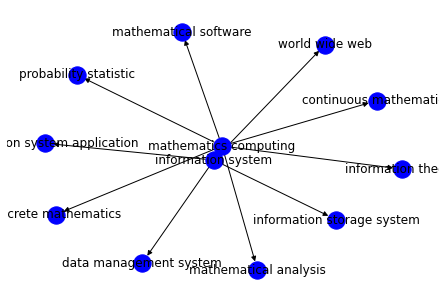

In [22]:
subgraph = DG.subgraph(list(nodes)[3:15])
pos = nx.spring_layout(subgraph)

nx.draw(subgraph, pos=pos, with_labels = True, node_color = 'b')
plt.show()

### Generating the bdd

#### Removes nodes with double or more inheritence from graph

In [23]:
## Removing nodes with multiple predecessors
problematic_nodes = list(redundancies_stats[redundancies_stats > 1].index)

# Makes a deep copy of the graph
DG_without_multiple_inheritence = DG.copy()

print("Number of problematic nodes:", len(problematic_nodes))

count_nodes_removed = 0

for el in problematic_nodes:
    if(el in list(DG_without_multiple_inheritence.nodes())):
        nodes_to_remove = [el] + list(nx.nodes(nx.dfs_tree(DG_without_multiple_inheritence, el)))

        count_nodes_removed += len(nodes_to_remove)

        DG_without_multiple_inheritence.remove_nodes_from(nodes_to_remove)
        

print("Number of nodes removed:", count_nodes_removed)
print("Number of remaining nodes:", len(DG_without_multiple_inheritence.nodes()))

Number of problematic nodes: 160
Number of nodes removed: 302
Number of remaining nodes: 1740


In [24]:
## With this new graph without cycles, we can fetch the roots:
list(nx.topological_sort(DG_without_multiple_inheritence))[:13]

['general reference',
 'mathematics computing',
 'information system',
 'security privacy',
 'network',
 'human-centered computing',
 'social professional topic',
 'theory computation',
 'computing methodology',
 'applied computing',
 'computer system organization',
 'hardware',
 'software engineering']

#### Concept pairs with label 0

In [25]:
## Get the 13 roots
roots = list(xml_df.iloc[1:14, -1])

list_of_concept_pairs_0 = []

for i in range(len(roots)):
    successors_of_i = set(list(nx.nodes(nx.dfs_tree(DG_without_multiple_inheritence, roots[i]))))
    for j in range(i+1, len(roots)):
        successors_of_j = set(list(nx.nodes(nx.dfs_tree(DG_without_multiple_inheritence, roots[j]))))
        
        ## Removes the common nodes in both branches
        l1 = list(successors_of_i - successors_of_j)
        l2 = list(successors_of_j - successors_of_i)
        
        ## Produces all possible pairs of concepts and adds them to the list
        list_of_concept_pairs_0 += cartesianProductOfLists(l1, l2)
        
print(len(list_of_concept_pairs_0))
list_of_concept_pairs_0[:10]

1361382


[('measurement', 'functional analysis'),
 ('measurement', 'combinatoric problem'),
 ('measurement', 'graph algorithm'),
 ('measurement', 'maximum likelihood estimation'),
 ('measurement', 'time series analysis'),
 ('measurement', 'bootstrapping'),
 ('measurement', 'graph enumeration'),
 ('measurement', 'differential variational inequality'),
 ('measurement', 'matchings factor'),
 ('measurement', 'algebraic topology')]

#### Concept pairs with label -1 or 1

In [26]:
def LinkedConceptPairs(current_node, predecessors, dfs_on_root):
    '''For each current node, we compute all the possible pairs between predecessors and current successors of the node.
        It is done in a recursive manner
    '''
    if(current_node in dfs_on_root.keys()):
        successors = dfs_on_root[current_node] 

        # To compute concept pairs of predecessors and successors, we use the cartesian product
        extracted_pairs = cartesianProductOfLists(predecessors, successors)
        
        # We then recursively find the pairs for the successors
        for succ in successors:
            extracted_pairs += LinkedConceptPairs(succ, predecessors + [succ], dfs_on_root)
            
        return extracted_pairs
    else:
        return []

In [27]:
## Get the 13 roots
roots = list(xml_df.iloc[1:14, -1])

list_of_concept_pairs_1 = []

for root in roots:
    dfs_on_root = nx.dfs_successors(DG, root)
    
    ## Going through the depth first search:    
    list_of_concept_pairs_1 += LinkedConceptPairs(root, predecessors=[root], dfs_on_root=dfs_on_root)
    
print(len(list_of_concept_pairs_1))
list_of_concept_pairs_1[:10]

5980


[('general reference', 'document type'),
 ('general reference', 'cross-computing tool technique'),
 ('general reference', 'survey overview'),
 ('general reference', 'reference work'),
 ('general reference', 'general conference proceeding'),
 ('general reference', 'biography'),
 ('general reference', 'general literature'),
 ('general reference', 'computing standard rfcs guideline'),
 ('document type', 'survey overview'),
 ('document type', 'reference work')]

#### Creates the dataframe

In [28]:
## Initializes the dict
labeled_concept_pair_dict = {"kw1":[], "kw2":[], "label":[]}

## Iterate over all concept pairs with label 1:
for concept_root, concept_leaf in list_of_concept_pairs_1:
    if(np.random.uniform(0,1)>0.5):
        labeled_concept_pair_dict['label'].append(-1) # leaf then root is -1
        labeled_concept_pair_dict['kw1'].append(concept_leaf)
        labeled_concept_pair_dict['kw2'].append(concept_root)

    else:
        labeled_concept_pair_dict['label'].append(1) # root then leaf is 1
        labeled_concept_pair_dict['kw1'].append(concept_root)
        labeled_concept_pair_dict['kw2'].append(concept_leaf)

number_of_pairs_with_label_0 = 20000
step = int(np.floor(len(list_of_concept_pairs_0)/ number_of_pairs_with_label_0))

for i in range(0, len(list_of_concept_pairs_0), step):
    labeled_concept_pair_dict['label'].append(0)
    
    index_1 = int(np.random.uniform(0,1)>0.5)
    index_2 = 1 - index_1
    labeled_concept_pair_dict['kw1'].append(list_of_concept_pairs_0[i][index_1])
    labeled_concept_pair_dict['kw2'].append(list_of_concept_pairs_0[i][index_2])
    
labeled_concept_pair_df = pd.DataFrame(labeled_concept_pair_dict)
labeled_concept_pair_df.tail()

,kw1,kw2,label
25996,software testing debugging,combinational synthesis,0
25997,combinational synthesis,power management,0
25998,software fault tolerance,pcb design layout,0
25999,pcb design layout,formal method,0
26000,documentation,pcb design layout,0


In [29]:
## Sanity Check
print(labeled_concept_pair_dict['kw1'][:10])
print(labeled_concept_pair_dict['kw2'][:10])
print(labeled_concept_pair_dict['label'][:10])

['document type', 'general reference', 'general reference', 'general reference', 'general reference', 'general reference', 'general reference', 'computing standard rfcs guideline', 'document type', 'document type']
['general reference', 'cross-computing tool technique', 'survey overview', 'reference work', 'general conference proceeding', 'biography', 'general literature', 'general reference', 'survey overview', 'reference work']
[-1, 1, 1, 1, 1, 1, 1, -1, 1, 1]


In [30]:
labeled_concept_pair_df.label.value_counts()

 0    20021
 1     2996
-1     2984
Name: label, dtype: int64

In [31]:
labeled_concept_pair_df.to_csv("Data/labeled_concept_pair_dataset.csv", index=False)

### Graph similarity measures
When the algorithm is trained we can try to recreate the original CCS tree and compute the graph edit distance between the original and the one created with the algorithm. <br>
Networkx similarity measures for graphs [here](https://networkx.org/documentation/stable/reference/algorithms/similarity.html). Theory is [here](http://www.xavierdupre.fr/app/mlstatpy/helpsphinx/c_algo/graph_distance.html#step-2-kruskal-kind-bijection-on-paths).

In [32]:
number_of_nodes = 150
nodes_DG_trunk  = list(DG.nodes())[:number_of_nodes]
nodes_DGW_trunk = list(DG_without_multiple_inheritence.nodes())[:number_of_nodes]

nx.graph_edit_distance(DG.subgraph(nodes_DG_trunk), DG_without_multiple_inheritence.subgraph(nodes_DGW_trunk))